# General Dependencies

In [1]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [2]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [3]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

17:28:27 INFO    1204325400.py:12: WORKING!


# Setup

In [4]:
from time import sleep

from core.controllers.adb import ADBController
from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

# ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks App Player")
ctrl = ADBController(device="localhost:5555")

In [5]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

c:\Users\magod\Anaconda3\envs\env_uma\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


17:28:33 INFO    ocr_local.py:146: OCRInterface initialized | lang=en device=cpu


In [6]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(
    ctrl=ctrl,
    weights=Settings.YOLO_WEIGHTS_UNITY_CUP,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV, Settings.YOLO_WEIGHTS_UNITY_CUP
)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

17:28:33 INFO    yolo_local.py:35: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma_unity_cup.pt
17:28:34 DEBUG   waiter.py:64: [waiter] init agent=player tag=player


# Lookup

## Real Time

17:28:39 DEBUG   1117181424.py:105: Screen Detection: Unknown | {'training_buttons': 0, 'tazuna': False, 'infirmary': False, 'rest': False, 'rest_summer': False, 'recreation': False, 'race_day': False, 'counts': {'button_white': 1}, 'pal_available': False}


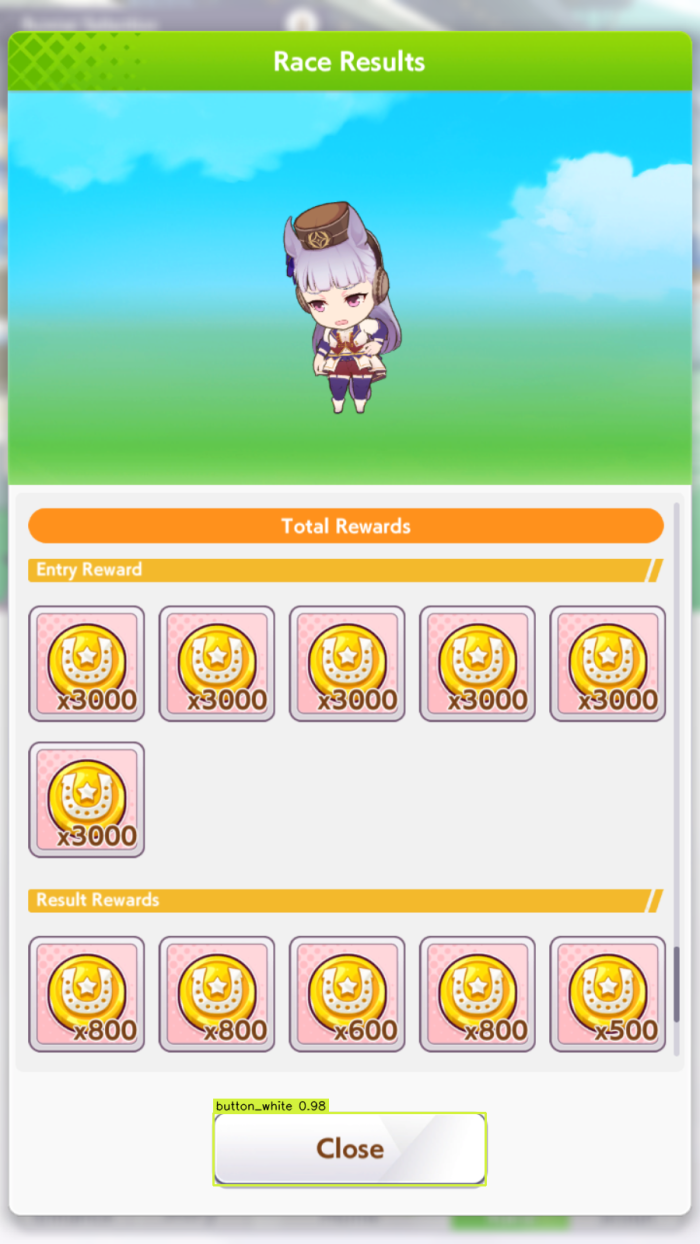

00 | button_white         | conf=0.977 | xyxy=(274.9,1431.1,624.0,1524.6)


In [7]:
from core.perception.analyzers.screen import classify_screen_unity_cup
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=0.61,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen_unity_cup(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


## Static

In [1]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------
from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from PIL import Image

"tests/data/events/event_support_kitasan_paying_it_forward.png"
img = Image.open("temp/bug1.png").convert("RGB")
ctrl_static = StaticImageController(img)
yolo_engine_static = LocalYOLOEngine(
    ctrl=ctrl_static,
    weights=Settings.YOLO_WEIGHTS,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)


assert ctrl_static.focus()

# recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine_static.recognize(
    imgsz=832,
    conf=0.1,
    iou=0.45,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


ImportError: cannot import name 'classify_screen' from 'core.perception.analyzers.screen' (d:\GitHub\UmAutoplay\core\perception\analyzers\screen.py)

In [ ]:
# Save segment
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Literal
from PIL import Image

def _clamp_box(x1: int, y1: int, x2: int, y2: int, w: int, h: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    # Ensure x2>x1 and y2>y1 (at least 1px box)
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return x1, y1, x2, y2

def _expand_box(x1: int, y1: int, x2: int, y2: int,
                w: int, h: int,
                pad_px: int = 0,
                pad_pct: float = 0.0) -> Tuple[int, int, int, int]:
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = pad_px + int(bw * pad_pct)
    py = pad_px + int(bh * pad_pct)
    return _clamp_box(x1 - px, y1 - py, x2 + px, y2 + py, w, h)

def crop_by_class(
    pil_img: Image.Image,
    dets: List[Dict],
    class_name: str,
    out_dir: str,
    *,
    conf_min: float = 0.0,
    mode: Literal["best","all","index"] = "best",
    index: Optional[int] = None,          # used when mode="index" (0-based within filtered list)
    pad_px: int = 0,
    pad_pct: float = 0.0,                 # e.g. 0.05 → +5% of box size on all sides
    prefix: Optional[str] = None,
    fmt: str = "png",                     # "png" or "jpg"
) -> List[Tuple[str, Image.Image, Dict]]:
    """
    Find detections with name == class_name and save crops to `out_dir`.

    Returns a list of (saved_path, crop_image, det_dict) in the order saved.
    If nothing matches, returns [].

    - mode="best": only highest-confidence match
      mode="index": only the Nth match after sorting by confidence (index required)
      mode="all": save all matches (sorted by confidence desc)
    """
    # Filter & sort candidates
    cands = [d for d in (dets or []) if str(d.get("name","")) == class_name and float(d.get("conf",0.0)) >= conf_min]
    cands.sort(key=lambda d: float(d.get("conf", 0.0)), reverse=True)

    if not cands:
        return []

    if mode == "best":
        chosen = [cands[0]]
    elif mode == "index":
        if index is None or index < 0 or index >= len(cands):
            return []
        chosen = [cands[index]]
    else:  # "all"
        chosen = cands

    # Prepare output
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    w, h = pil_img.size

    results: List[Tuple[str, Image.Image, Dict]] = []
    for rank, d in enumerate(chosen):
        x1, y1, x2, y2 = d.get("xyxy", (0,0,0,0))
        # Round to ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # Optional padding and clamp
        x1, y1, x2, y2 = _expand_box(x1, y1, x2, y2, w, h, pad_px=pad_px, pad_pct=pad_pct)

        crop = pil_img.crop((x1, y1, x2, y2))

        base = prefix or class_name
        conf = float(d.get("conf", 0.0))
        # e.g. ui_energy_rank0_0.95_0348-0090-0622-0132.png
        fname = f"{base}_rank{rank}_{conf:.2f}_{x1:04d}-{y1:04d}-{x2:04d}-{y2:04d}.{fmt.lower()}"
        save_path = str(out_path / fname)
        # Save with sane defaults
        save_kwargs = {}
        if fmt.lower() == "jpg":
            save_kwargs.update({"quality": 95, "optimize": True})
        crop.save(save_path, **save_kwargs)

        results.append((save_path, crop, d))

    return results

_ = crop_by_class(
    game_img,
    parsed_objects_screen,
    class_name="event_card",
    out_dir="assets",
    conf_min=0.60,
    mode="best",
    pad_pct=0.01,   # add ~X% padding for safety
)


# Segment by segment testing

## Lobby

In [8]:
# core/actions/unity_cup/lobby.py
from __future__ import annotations


from core.actions.lobby import LobbyFlow
from core.constants import UNITY_TURNS_CLASS
from core.controllers.base import IController
from core.perception.extractors.state import (
    extract_mood,
    extract_infirmary_on,
    extract_skill_points,
    extract_goal_text,
    extract_energy_pct,
    extract_turns,
    find_best,
)
from core.perception.yolo.interface import IDetector
from core.utils.logger import logger_uma
from core.utils.race_index import date_key_from_dateinfo
from core.utils.waiter import Waiter
from core.utils.yolo_objects import collect

from core.utils.date_uma import (
    is_summer_in_two_or_less_turns,
    date_is_confident,
)

class LobbyFlowUnityCup(LobbyFlow):
    """
    Encapsulates all Lobby decisions & navigation.
    Composes RaceFlow and centralizes waits via a single Waiter.
    """

    def __init__(
        self,
        ctrl: IController,
        ocr,
        yolo_engine: IDetector,
        waiter: Waiter,
        *,
        minimum_skill_pts: int = 500,
        auto_rest_minimum: int = 24,
        prioritize_g1: bool = False,
        process_on_demand=True,
        interval_stats_refresh=1,
        max_critical_turn=8,
        plan_races={},
    ) -> None:
        super().__init__(
            ctrl,
            ocr,
            yolo_engine,
            waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            process_on_demand=process_on_demand,
            interval_stats_refresh=interval_stats_refresh,
            max_critical_turn=max_critical_turn,
            plan_races=plan_races,
            date_layout="right",
        )

    # --------------------------
    # Public entry point
    # --------------------------
    def process_turn(self):
        """
        Evaluate the Lobby and take the next action.
        Returns a short outcome string:
          - "RACED"          → we entered/finished a race flow
          - "INFIRMARY"      → we went to infirmary
          - "RESTED"         → we chose rest/recreation
          - "TO_TRAINING"    → we navigated to the training screen
          - "CONTINUE"       → we did a minor click or nothing

        optional extra message
        """
        img, dets = collect(
            self.yolo_engine,
            imgsz=self.waiter.cfg.imgsz,
            conf=self.waiter.cfg.conf,
            iou=self.waiter.cfg.iou,
            tag="lobby_state",
        )

        if not self.process_on_demand:
            self._update_state(
                img, dets
            )  # -> Very expensive, calculate as you need better

        # --- Critical goal logic & early racing opportunities ---

        if self.process_on_demand:
            self._process_date_info(img, dets)
            logger_uma.info(
                f"Date: {self.state.date_info} | raw: {self.state.career_date_raw}"
            )

        if self.process_on_demand:
            self.state.energy = extract_energy_pct(img, dets)

        # --- Race planning (explicit list takes precedence; else G1 if available) ---
        self._plan_race_today()

        current_date_key = (
            date_key_from_dateinfo(self.state.date_info)
            if self.state and getattr(self.state, "date_info", None)
            else None
        )
        if (
            self._skip_race_once
            and self._skip_guard_key
            and current_date_key
            and current_date_key != self._skip_guard_key
        ):
            logger_uma.info(
                "[planned_race] skip guard released: %s -> %s",
                self._skip_guard_key,
                current_date_key,
            )
            self._skip_race_once = False
            self._skip_guard_key = None

        # If we have a planned race today, go race (subject to early-guard rules)
        if self.state.planned_race_name:
            # First-Junior-Day guard (no races available there)
            is_first_junior_date = (
                bool(self.state.date_info)
                and date_is_confident(self.state.date_info)
                and self.state.date_info.year_code == 1
                and self.state.date_info.month == 7
                and self.state.date_info.half == 1
            )
            guard_extra = {
                "first_junior": is_first_junior_date,
                "skip_guard": self._skip_race_once,
            }
            self._log_planned_race_decision(
                action="guard_evaluate",
                plan_name=self.state.planned_race_name,
                extra=guard_extra,
            )
            if not is_first_junior_date and not self._skip_race_once:
                reason = f"Planned race: {self.state.planned_race_name}"
                self._log_planned_race_decision(
                    action="enter_race",
                    plan_name=self.state.planned_race_name,
                    reason="guard_passed",
                    extra=guard_extra,
                )
                self._skip_race_once = False
                return "TO_RACE", reason
            else:
                suppression_reasons = []
                if is_first_junior_date:
                    suppression_reasons.append("first_junior_date")
                if self._skip_race_once:
                    suppression_reasons.append("skip_guard")
                self._log_planned_race_decision(
                    action="guard_suppressed",
                    plan_name=self.state.planned_race_name,
                    reason=",".join(suppression_reasons) or "unknown",
                    extra=guard_extra,
                )
                logger_uma.debug(
                    "[lobby] Planned race suppressed by first-junior-day/skip flag."
                )
            self._skip_race_once = False
            self._skip_guard_key = None

        if self.process_on_demand:
            self._process_turns_left(img, dets)
            self._process_turns_special(img, dets)

        if self.state.turn <= self.max_critical_turn:
            if not self._skip_race_once and self.state.energy is not None and self.state.energy > 2:
                # [Optimization] 10 steps for goal, or unknown turns or -1 turns, check goal
                outcome_bool, reason = self._maybe_do_goal_race(img, dets)
                if outcome_bool:
                    return "TO_RACE", reason

        # After special-case goal racing, clear the one-shot skip guard.
        self._skip_race_once = False

        if self.process_on_demand:
            self.state.infirmary_on = extract_infirmary_on(img, dets, threshold=0.60)

        # --- Infirmary handling (only outside summer) ---
        if self.state.infirmary_on and (self.state.is_summer is False):
            if self._go_infirmary():
                return "INFIRMARY", "Infirmary to remove blue condition"

        # --- Energy management (rest) ---
        if self.state.energy is not None:
            if self.state.energy <= self.auto_rest_minimum:
                reason = f"Energy too low, resting: auto_rest_minimum={self.auto_rest_minimum}"
                if self._go_rest(reason=reason):
                    return "RESTED", reason
            elif (
                self.state.energy <= 50
                and self.state.date_info
                and is_summer_in_two_or_less_turns(self.state.date_info)
            ):
                reason = "Resting to prepare for summer"
                if self._go_rest(reason=reason):
                    return "RESTED", reason

        if self.process_on_demand:
            self.state.mood = extract_mood(self.ocr, img, dets, conf_min=0.3)

        if self.state.mood[-1] < 0:
            logger_uma.warning("UNKNOWN mood!")
        # --- Mood (for training policy)---
        # Navigate to Training if nothing else

        if self._go_training_screen_from_lobby(img, dets):
            return "TO_TRAINING", "No critical stuff going to train"

        return "CONTINUE", "Unknown"

    def _update_state(self, img, dets) -> None:
        # Skill points, goal & energy
        self.state.skill_pts = extract_skill_points(self.ocr, img, dets)
        self.state.goal = extract_goal_text(self.ocr, img, dets)
        self.state.energy = extract_energy_pct(img, dets)

        self._update_stats(img, dets)
        # Turns & career date parsing
        self._process_turns_left(img, dets)
        self._process_turns_special(img, dets)
        self._process_date_info(img, dets)
        # Infirmary & mood
        self.state.infirmary_on = extract_infirmary_on(img, dets, threshold=0.60)
        self.state.mood = extract_mood(self.ocr, img, dets, conf_min=0.3)

    def _process_turns_left(self, img, dets):

        new_turn = extract_turns(self.ocr, img, dets, add_gap_y2=False)
        if new_turn != -1:
            ref_turn = self.last_turns_left_prediction or self.state.turn or -1
            diff = abs(ref_turn - new_turn)
            if diff < 5 or ref_turn == -1 or self.state.turn <= 2:
                # accept only if new change is not too big, or if last detected turn was near to finish turns left
                self.state.turn = new_turn
            elif self.state.turn > 1:
                logger_uma.debug(
                    f"Naive prediction. Last turn was: {self.state.turn}, so now it should be at most {self.state.turn - 1}"
                )
                self.state.turn -= 1
        elif self.state.turn > 0:
            # Naive prediction
            logger_uma.debug(
                f"Naive prediction. Last turn was: {self.state.turn}, so now it should be at most {self.state.turn - 1}"
            )
            self.state.turn -= 1
        self.last_turns_left_prediction = new_turn

    def _process_turns_special(self, img, dets):
        new_turns_special = extract_turns(
            self.ocr,
            img,
            dets,
            turns_class=UNITY_TURNS_CLASS,
            add_gap_y1=False, add_gap_y2=False
        )

        if new_turns_special != -1:
            ref_turns_special = (
                getattr(self, "last_turns_special_prediction", None)
                or self.state.turns_special
                or -1
            )
            diff_special = abs(ref_turns_special - new_turns_special)

            if diff_special < 5 or ref_turns_special == -1 or self.state.turns_special <= 2:
                self.state.turns_special = new_turns_special
            elif self.state.turns_special > 1:
                logger_uma.debug(
                    "[turns_special] Naive prediction. Last value was %s, so now it "
                    "should be at most %s",
                    self.state.turns_special,
                    self.state.turns_special - 1,
                )
                self.state.turns_special -= 1
        elif self.state.turns_special > 0:
            logger_uma.debug(
                "[turns_special] Naive prediction. Last value was %s, so now it should "
                "be at most %s",
                self.state.turns_special,
                self.state.turns_special - 1,
            )
            self.state.turns_special -= 1

        self.last_turns_special_prediction = new_turns_special


In [9]:
assert ctrl.focus()
lobby = LobbyFlowUnityCup(
    ctrl,
    ocr,
    yolo_engine,
    waiter,
    # max_critical_turn=13,
    # minimum_skill_pts=minimum_skill_pts,
    # auto_rest_minimum=auto_rest_minimum,
    # prioritize_g1=prioritize_g1,
    # interval_stats_refresh=interval_stats_refresh,
    # plan_races=self.plan_races,
)

## MOCK
img, dets = collect(
    lobby.yolo_engine,
    imgsz=lobby.waiter.cfg.imgsz,
    conf=lobby.waiter.cfg.conf,
    iou=lobby.waiter.cfg.iou,
    tag="lobby_state",
)
res_turn = lobby.process_turn()
print(res_turn)
print(lobby.state)
# lobby._update_turns_special(img, dets)

13:15:01 DEBUG   lobby.py:639: [date] prev: None. Cand: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None). accepted: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None)
13:15:01 INFO    lobby.py:640: [date] initial: None -> Y1
13:15:01 INFO    2985971458.py:96: Date: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None) | raw: Junior Year Pre-Debut
13:15:01 WARNING state.py:171: Unrecognized turns
13:15:01 INFO    lobby.py:959: [lobby] No critical actions → go Train
13:15:02 DEBUG   state.py:367: Stat 19 < 90 without trailing letter; treating as unrecognized (raw='19')
13:15:02 DEBUG   lobby.py:394: [stats] imputed ['WIT'] with avg=119
13:15:02 INFO    lobby.py:411: [stats] update: SPD:-1->96, STA:-1->146, PWR:-1->140, GUTS:-1->93
('TO_TRAINING', 'No critical stuff going to train')
LobbyState(goal=None, energy=95, skill_pts=0, infirmary_on=False, turn=11, turns_special=-1, career_date_raw='Junior Year Pre-Debut', date_in

## Skills

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

skills_flow = SkillsFlow(ctrl, ocr, yolo_engine, waiter)
skills_flow.buy(skill_list=[
    "Focus"
])


## Races

In [ ]:
race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
race_flow.run(desired_race_name="Oro Cup", date_key="Y3-11-1")
# race_flow.run(desired_race_name="JBC Ladies' Classic", date_key="Y3-11-1")

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
# race_flow._ensure_in_raceday()
# race_flow.run(ensure_navigation=False, select_style="pace")
race_flow.lobby()

## Events

In [7]:
# 🔧 Build (re-run only when you change datasets or add new images)
# from core.utils.event_processor import build_catalog

from IPython.display import display
from PIL import Image
import json

def show_image(path, title=None, max_size=160):
    if not path:
        print("(no image)")
        return
    try:
        im = Image.open(path).convert("RGB")
        # shrink for notebook
        w, h = im.size
        scale = min(max_size / max(w, h), 1.0)
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)))
        if title:
            print(title)
        display(im)
    except Exception as e:
        print(f"[show_image] failed: {e} | path={path}")

def preview_option(rec, pick):
    opts = rec.options or {}
    items = opts.get(str(pick), [])
    if not items:
        print(f"(no data for option {pick})")
        return
    print(f"First outcome for option {pick}:")
    print(json.dumps(items[0], ensure_ascii=False, indent=2))


print("Building catalog…")
build_catalog()

Building catalog…
[build_catalog] Wrote 907 events → datasets\in_game\event_catalog.json


In [ ]:
# 🔁 Load catalog & prefs into memory (kept in notebook state)
from core.utils.event_processor import CATALOG_JSON, Catalog, UserPrefs

cat = Catalog.load(CATALOG_JSON)

In [ ]:
# from core.utils.event_processor import Query, retrieve_best


ocr_title = "Just an Acupuncturist, No Worries!"

portrait_crop = "temp/Kitasan Black_SSR.png"

q = Query(
    ocr_title=ocr_title,
    # type_hint="support",            # support | trainee | scenario
    # name_hint="Kitasan Black",      # optional
    # rarity_hint="R",              # optional
    # portrait_path=portrait_crop,
    # chain_step_hint=2,   # tell the retriever which chain step you’re seeing
)

candidates = retrieve_best(cat, q, top_k=5, min_score=0.1)
for i, r in enumerate(candidates, 1):
    print(f"{i:>2}. {r.rec.key:80s} | score={r.score:.3f}  "
          f"(text={r.text_sim:.3f} img={r.img_sim:.3f} bonus={r.hint_bonus:.3f})")

best = candidates[0]
print("\nBest match:", best.rec.key)
pick = prefs.pick_for(best.rec)
print("Resolved option (with prefs):", pick)
preview_option(best.rec, pick)
show_image(best.rec.image_path, title="Matched catalog image")


In [ ]:
from core.utils.img import to_bgr


deck = [
    {"name": "Kitasan Black", "rarity": "SSR", "attribute": "SPD"},
    {"name": "Gold Ship", "rarity": "SSR", "attribute": "STA"},
    {"name": "Matikanetannhauser", "rarity": "SSR", "attribute": "GUTS"},
    {"name": "Tokai Teio", "rarity": "SSR", "attribute": "SPD"},
    {"name": "Tazuna Hayakawa", "rarity": "SSR", "attribute": "PAL"},
    {"name": "Nishino Flower", "rarity": "SSR", "attribute": "WIT"},
]

# "./temp/hints/hint_kitasan.png"
image_path = "./temp/hints/hint_kitasan.png"
crop_bgr = to_bgr(image_path)
matcher = get_support_matcher(deck or Settings.SUPPORT_DECK, min_confidence=0.25)
match = matcher.best_match(crop_bgr)
print(match)


TemplateMatch(name='Kitasan Black', score=0.47795045055269236, tm_score=0.42113966494798655, hash_score=0.59375, hist_score=0.6440268508910174, path='web\\public\\events\\support_icon_training\\Kitasan Black.png', metadata={'name': 'Kitasan Black', 'rarity': 'SSR', 'attribute': 'SPD'})


## Training policy

In [26]:
import pprint

from core.settings import Constants
assert ctrl.focus()
training_state, cur_img, cur_parsed = scan_training_screen(
    ctrl,
    ocr,
    yolo_engine,
    energy=90,
)
Settings.ACTIVE_SCENARIO = "unity_cup"
sv_rows = compute_support_values_dispatch(training_state)

for r in sv_rows:
    tile_idx = int(r['tile_idx'])
    tile_type = Constants.map_tile_idx_to_type.get(tile_idx, f"Unknown[{tile_idx}]")
    logger_uma.info(
        f"View [{tile_idx}] {tile_type}: "
        f"SV={r['sv_total']:.2f}  "
        f"fail={r['failure_pct']}% (≤ {r['risk_limit_pct']}% ? {r['allowed_by_risk']})  "
        f"greedy={r['greedy_hit']}"
    )
    for note in r["notes"]:
        logger_uma.info(f"   - {note}")

# pprint.pprint(training_state)

17:19:08 DEBUG   2507666266.py:306: [unity_spirit] Tile spirits detected=2
17:19:09 DEBUG   2507666266.py:306: [unity_spirit] Tile spirits detected=2
17:19:10 DEBUG   2507666266.py:306: [unity_spirit] Tile spirits detected=2
17:19:11 DEBUG   2507666266.py:306: [unity_spirit] Tile spirits detected=2
17:19:12 DEBUG   2507666266.py:306: [unity_spirit] Tile spirits detected=2
17:19:12 INFO    2459777120.py:17: View [0] SPD: SV=3.00  fail=0% (≤ 20% ? True)  greedy=False
17:19:12 INFO    2459777120.py:24:    - rainbow (support_card): +1.00
17:19:12 INFO    2459777120.py:24:    - support_card orange: +0.00
17:19:12 INFO    2459777120.py:24:    - rainbow (support_card): +1.00
17:19:12 INFO    2459777120.py:24:    - support_card orange: +0.00
17:19:12 INFO    2459777120.py:24:    - Rainbow combo (2): +0.50
17:19:12 INFO    2459777120.py:24:    - White spirits: +0.50 (fill=1, exploded=0)
17:19:12 INFO    2459777120.py:24:    - Dynamic risk: SV=3.00 → base 20% × 1.00 = 20%
17:19:12 INFO    245977

## Static check

In [ ]:
# from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
from core.settings import Settings

img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl = StaticImageController(img)

assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))


In [ ]:
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

catalog = Catalog.load(CATALOG_JSON)
user_prefs = UserPrefs.load(USER_PREFS)

game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

event_flow = EventFlow(ctrl, ocr, yolo_engine, waiter, catalog, user_prefs)
decision = event_flow.process_event_screen(game_img, parsed_objects_screen)
decision

## Agent

In [54]:
# core/actions/unity_cup/training_policy.py
from __future__ import annotations

from typing import Dict, List, Optional, Sequence, Tuple, cast

from core.types import TrainAction
from core.constants import DEFAULT_TILE_TO_TYPE, MOOD_MAP
from core.types import MoodName
from core.utils.date_uma import (
    DateInfo,
    is_final_season,
    is_junior_year,
    is_pre_debut,
    is_summer,
    is_summer_in_next_turn,
    is_summer_in_two_or_less_turns,
    near_mood_up_event,
    parse_career_date,
)
from core.utils.logger import logger_uma
from core.settings import Settings
from core.utils.race_index import RaceIndex, date_key_from_dateinfo
from core.utils.training_policy_utils import any_wit_rainbow, best_wit_tile, director_tile_and_color, normalize_mood, tiles_with_hint, best_tile

# ---------- Action Enum ----------
def decide_action_training(
    sv_rows: List[Dict],
    *,
    mood,
    turns_left,
    career_date: DateInfo,
    energy_pct: int,
    prioritize_g1: bool,
    stats={},
    reference_stats={
        "SPD": 1150,
        "STA": 900,
        "PWR": 700,
        "GUTS": 300,
        "WIT": 400,
    },
    # Tie-break context
    tile_to_type: Optional[Dict[int, str]] = None,
    priority_stats: Optional[Sequence[str]] = None,
    # Policy thresholds (can be tuned in config later)
    minimal_mood: str = "NORMAL",  # below this → recreation (if also < 'GREAT')
    max_pick_sv_top: float = 3.5,
    next_pick_sv_top: float = 2.5,
    late_pick_sv_top: float = 2,
    low_pick_sv_gate: float = 1.75,
    energy_rest_gate_lo: int = 35,  # early branch
    energy_rest_gate_mid: int = 50,  # URA branch
    energy_race_gate: int = 68,  # summer / late branch
    skip_race=False,
    # Runtime settings from preset
    race_if_no_good_value: bool = False,
) -> Tuple[TrainAction, Optional[int], str]:
    """
    Return the decided action and the target tile index (or None when not applicable).
    The flow mirrors your diagrams; 'events check' nodes are ignored here.
    """

    # Normalize helpers
    tile_to_type = tile_to_type or DEFAULT_TILE_TO_TYPE
    priority_stats = list(
        priority_stats or ["SPD", "STA", "WIT", "PWR", "GUTS"]
    )  # sensible default
    for i in range(len(priority_stats)):
        priority_stats[i] = priority_stats[i].upper()

    for i in range(len(tile_to_type)):
        tile_to_type[i] = tile_to_type[i].upper()
    (mood_txt, mood_score) = normalize_mood(mood)

    if isinstance(career_date, str):
        di = parse_career_date(career_date)
    elif isinstance(career_date, DateInfo):
        di = career_date

    # Collect reasoning as we go
    reasons: List[str] = []

    def because(msg: str) -> None:
        reasons.append(msg)

    # Convenience views
    allowed_rows = [r for r in sv_rows if r.get("allowed_by_risk", False)]
    sv_by_tile = {int(r["tile_idx"]): float(r.get("sv_total", 0.0)) for r in sv_rows}

    # -------- Cap-aware filtering (do not train stats already at/above reference) --------
    def _stat_of_tile(idx: int) -> str:
        return str(tile_to_type.get(int(idx), "")).upper()

    try:
        capped_stats = set()
        for k, target in (reference_stats or {}).items():
            kU = str(k).upper()
            cur = int(stats.get(kU, -1))
            if cur >= 0 and int(target) > 0 and cur >= int(target):
                capped_stats.add(kU)
    except Exception:
        capped_stats = set()

    raw_hint_tiles = tiles_with_hint(sv_rows)
    hint_override_stats = set()
    if Settings.HINT_IS_IMPORTANT:
        for t in raw_hint_tiles:
            stat = _stat_of_tile(int(t))
            if not stat:
                continue
            passes_risk = any(
                (r.get("tile_idx") == t) and r.get("allowed_by_risk", False)
                for r in sv_rows
            )
            if stat in capped_stats and passes_risk:
                hint_override_stats.add(stat)

    def _exclude_capped(rows):
        return [
            r
            for r in rows
            if (
                (stat := _stat_of_tile(int(r["tile_idx"]))) not in capped_stats
                or stat in hint_override_stats
            )
        ]

    allowed_rows_filtered = _exclude_capped(allowed_rows)

    # WIT helpers respect caps too
    wit_capped_without_hint = "WIT" in capped_stats and "WIT" not in hint_override_stats
    best_wit_any = (
        None
        if wit_capped_without_hint
        else best_wit_tile(
            sv_rows, allowed_only=True, min_sv=0.0, tile_to_type=tile_to_type
        )
    )
    best_wit_low = (
        None
        if wit_capped_without_hint
        else best_wit_tile(
            sv_rows,
            allowed_only=True,
            min_sv=low_pick_sv_gate,
            tile_to_type=tile_to_type,
        )
    )

    # Hinted tiles that pass risk and are uncapped (or explicitly allowed via hint override)
    hint_tiles = [
        t
        for t in raw_hint_tiles
        if any(
            (r["tile_idx"] == t) and r.get("allowed_by_risk", False) for r in sv_rows
        )
        and (
            _stat_of_tile(int(t)) not in capped_stats
            or _stat_of_tile(int(t)) in hint_override_stats
        )
    ]
    best_allowed_tile_25 = best_tile(
        allowed_rows_filtered,
        min_sv=max_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    best_allowed_tile_20 = best_tile(
        allowed_rows_filtered,
        min_sv=next_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    best_allowed_any = best_tile(
        allowed_rows_filtered,
        min_sv=-1.0,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )

    top3_stats = [s.upper() for s in priority_stats[:3]]

    def _best_tile_for_stats(
        rows: Sequence[Dict], stats_subset: Sequence[str], min_sv: float = -1.0
    ) -> Tuple[Optional[int], float]:
        if not stats_subset:
            return None, 0.0
        stats_set = {s.upper() for s in stats_subset}
        pool = [
            r
            for r in rows
            if _stat_of_tile(int(r["tile_idx"])) in stats_set
            and float(r.get("sv_total", 0.0)) >= min_sv
        ]
        if not pool:
            return None, 0.0
        rbest = max(pool, key=lambda rr: float(rr.get("sv_total", 0.0)))
        return int(rbest["tile_idx"]), float(rbest.get("sv_total", 0.0))

    top3_tile_idx, top3_tile_sv = _best_tile_for_stats(
        allowed_rows_filtered, top3_stats, -1.0
    )
    top3_tile_stat = _stat_of_tile(int(top3_tile_idx)) if top3_tile_idx is not None else None

    PRIORITY_SV_DIFF_THRESHOLD = 0.75
    PRIORITY_TOP3_MIN_SV = 0.5
    PRIORITY_EXCEPTIONAL_SV = 4.1

    def _apply_priority_guard(candidate_idx: Optional[int], *, context: str) -> Optional[int]:
        if candidate_idx is None or top3_tile_idx is None:
            return candidate_idx
        candidate_stat = _stat_of_tile(int(candidate_idx))
        if candidate_stat in top3_stats:
            return candidate_idx
        candidate_sv = sv_of(candidate_idx)
        if candidate_sv >= PRIORITY_EXCEPTIONAL_SV:
            because(
                f"Priority guard skipped: {candidate_stat} SV {candidate_sv:.2f} ≥ {PRIORITY_EXCEPTIONAL_SV:.2f} considered exceptional"
            )
            return candidate_idx
        diff = candidate_sv - top3_tile_sv
        if top3_tile_sv >= PRIORITY_TOP3_MIN_SV and diff <= PRIORITY_SV_DIFF_THRESHOLD:
            because(
                f"Priority guard: {context} best option {candidate_stat} SV {candidate_sv:.2f} is only {diff:.2f} above top-3 {top3_tile_stat} SV {top3_tile_sv:.2f} → prefer top-3 stat"
            )
            return top3_tile_idx
        return candidate_idx

    def sv_of(idx: Optional[int]) -> float:
        return sv_by_tile.get(int(idx), 0.0) if idx is not None else 0.0

    # -----------------------------
    # Top of the flow
    # -----------------------------

    # -------------------------------------------------
    # Distribution-aware nudge (before step 1)
    # If a top-3 priority stat is undertrained vs. reference distribution
    # by ≥ (UNDERTRAIN_THRESHOLD)% and its best SV is within 1.5 of the best overall, pick it.
    # -------------------------------------------------
    # Use the configurable threshold from Settings, defaulting to 6% if not set
    UNDERTRAIN_DELTA = (
        getattr(Settings, "UNDERTRAIN_THRESHOLD", 6.0) / 100.0
    )  # Convert percentage to decimal
    MAX_SV_GAP = 1.25

    try:
        # Consider only known stats (ignore -1/0)
        keys = ["SPD", "STA", "PWR", "GUTS", "WIT"]
        known_keys = [k for k in keys if max(0, int(stats.get(k, -1))) > 0]

        # If hint is important ignore undertrain stat check, prioritize hint
        if known_keys and not (Settings.HINT_IS_IMPORTANT and len(hint_tiles) > 0):
            # Normalize reference to the same subset
            ref_sum = sum(max(0, int(reference_stats.get(k, 0))) for k in known_keys)
            cur_sum = sum(max(0, int(stats.get(k, 0))) for k in known_keys)

            if ref_sum > 0 and cur_sum > 0:
                ref_dist = {
                    k: max(0, int(reference_stats.get(k, 0))) / ref_sum
                    for k in known_keys
                }
                cur_dist = {
                    k: max(0, int(stats.get(k, 0))) / cur_sum for k in known_keys
                }
                deltas = {
                    k: ref_dist[k] - cur_dist[k] for k in known_keys
                }  # +ve → undertrained
                logger_uma.debug(f"STATS deltas respect 'ideal' distribution: {deltas}")
                # Get the top N stats to focus on, based on priority_stats or default order
                default_priority = ["SPD", "STA", "WIT", "PWR", "GUTS"]
                effective_priority = (
                    priority_stats if priority_stats else default_priority
                )
                top_n = effective_priority[: Settings.TOP_STATS_FOCUS]

                # Log which stats we're focusing on
                logger_uma.debug(
                    f"Focusing on top {Settings.TOP_STATS_FOCUS} stats: {top_n}"
                )

                # Find stats that are undertrained and in our focus list
                cand = [
                    (k, deltas[k])
                    for k in known_keys
                    if k in top_n and deltas[k] >= UNDERTRAIN_DELTA
                ]

                # If no candidates in top N, consider all stats but with lower priority
                if (
                    not cand and Settings.TOP_STATS_FOCUS < 5
                ):  # Only if we're not already considering all
                    cand = [
                        (k, deltas[k] * 0.5)  # Reduce priority for non-focus stats
                        for k in known_keys
                        if deltas[k] >= UNDERTRAIN_DELTA
                    ]

                if cand:
                    logger_uma.debug(f"Undertrain candidates: {cand}")
                    # Sort by how undertrained they are (highest gap first)
                    cand.sort(key=lambda kv: kv[1], reverse=True)
                    under_stat, gap = cand[0]

                    # Log decision making
                    if len(cand) > 1:
                        logger_uma.debug(
                            f"Selected {under_stat} (gap: {gap:.2f}) from candidates: "
                            f"{', '.join(f'{k}({v:.2f})' for k, v in cand)}"
                        )

                    # Best allowed overall
                    top_allowed_idx = best_allowed_any
                    top_allowed_sv = sv_of(top_allowed_idx)

                    # Best allowed tile for that specific stat
                    def _best_tile_of_type(
                        rows, stat: str, min_sv: float, tmap: Dict[int, str]
                    ):
                        pool = [
                            r
                            for r in rows
                            if str(tmap.get(int(r["tile_idx"]), "")).upper()
                            == stat.upper()
                            and float(r.get("sv_total", 0.0)) >= min_sv
                        ]
                        if not pool:
                            return None, 0.0
                        rbest = max(pool, key=lambda rr: float(rr.get("sv_total", 0.0)))
                        return int(rbest["tile_idx"]), float(rbest.get("sv_total", 0.0))

                    # respect caps here by using allowed_rows_filtered
                    under_idx, under_sv = _best_tile_of_type(
                        allowed_rows_filtered, under_stat, -1.0, tile_to_type
                    )

                    gap_top_under = top_allowed_sv - under_sv
                    flexible_gap = MAX_SV_GAP

                    # Wit h at least some value, default >= 0.5
                    if under_idx is not None:
                        under_sv = float(under_sv or 0.0)
                        severe_gap = gap >= UNDERTRAIN_DELTA * 2

                        if gap > UNDERTRAIN_DELTA * 1.5:
                            # accept more gap respect to best play
                            flexible_gap += 0.25
                        if severe_gap:
                            # extra slack when we are drastically under the reference
                            flexible_gap += 1

                        min_sv_gate = max(0.5, low_pick_sv_gate / 2)
                        meets_sv_requirement = under_sv >= min_sv_gate or severe_gap

                        if gap > UNDERTRAIN_DELTA and (
                            (top_allowed_idx is None or gap_top_under < flexible_gap)
                            and meets_sv_requirement
                        ):
                            because(
                                f"Undertrained {under_stat} by {gap:.1%} vs reference; "
                                f"choosing its best SV {under_sv:.2f} (overall best {top_allowed_sv:.2f}, current gap between best option and undertrained option={gap_top_under:.2f} < flexible_gap={flexible_gap}). "
                                + ("Severity override engaged; " if severe_gap else "")
                                + "So let's train under stat tile"
                            )
                            return (
                                TrainAction.TRAIN_MAX,
                                under_idx,
                                "; ".join(reasons),
                            )
                    else:
                        because(
                            f"Undertrained {under_stat} by {gap:.1%} vs reference; "
                            f"but the TOP option is better with SV {top_allowed_sv:.2f}, gap={gap} ) or is not worth it to train under_stat"
                        )
                else:
                    logger_uma.debug(
                        f"No undertrain candidates, Threshold: {UNDERTRAIN_DELTA}. Keys: {known_keys}. Stats checked: {top_n}"
                    )
    except Exception as _e:
        # Be permissive—never break the policy due to stats math
        because(f"Distribution check skipped due to stats error: {_e}")
        logger_uma.error(f"Distribution check skipped due to stats error: {_e}")
    # 1) If max SV option is >= 2.5 → select TRAIN_MAX (tie → priority order)
    if best_allowed_tile_25 is not None:
        because(
            f"Top SV ≥ {max_pick_sv_top} allowed by risk → pick tile {best_allowed_tile_25}"
        )
        target_tile = _apply_priority_guard(
            best_allowed_tile_25, context=f"SV ≥ {max_pick_sv_top}"
        )
        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))

    # URA Finale branch
    if is_final_season(di):
        # No rest allowed for now
        if hint_tiles:
            hinted = max(hint_tiles, key=lambda t: sv_of(t))
            because("URA Finale: take available hint to get more discounts")
            return (TrainAction.TAKE_HINT, hinted, "; ".join(reasons))

        # Re-target inheritance thresholds in final season:
        # 1) For top-3 priority stats, pick the first whose current value < 600.
        #    (Ignore caps here; thresholds outrank reference targets in URA.)
        top3_prio = [s.upper() for s in (priority_stats or [])][:3]

        def _best_tile_of_type(rows, stat: str, min_sv: float, tmap: Dict[int, str]):
            pool = [
                r
                for r in rows
                if str(tmap.get(int(r["tile_idx"]), "")).upper() == stat.upper()
                and float(r.get("sv_total", 0.0)) >= min_sv
            ]
            if not pool:
                return None, 0.0
            rbest = max(pool, key=lambda rr: float(rr.get("sv_total", 0.0)))
            return int(rbest["tile_idx"]), float(rbest.get("sv_total", 0.0))

        # (a) push any top-3 stat to 600 first
        for stat_name in top3_prio:
            curv = int(stats.get(stat_name, -1))
            if curv >= 0 and curv < 600:
                idx600, sv600 = _best_tile_of_type(
                    allowed_rows, stat_name, -1.0, tile_to_type
                )
                if idx600 is not None:
                    because(
                        f"URA Finale: raise {stat_name} towards 600 (cur={curv}) → tile {idx600}"
                    )
                    return (TrainAction.TRAIN_MAX, idx600, "; ".join(reasons))

        # (b) if all ≥ 600, pick the top-3 stat closest to 1200 but < 1170
        near_candidates = []
        for stat_name in top3_prio:
            curv = int(stats.get(stat_name, -1))
            if curv >= 0 and curv < 1170:
                near_candidates.append((stat_name, curv))
        if near_candidates:
            # Choose the one with the largest current value (closest to 1200)
            target_stat = max(near_candidates, key=lambda kv: kv[1])[0]
            idx1170, sv1170 = _best_tile_of_type(
                allowed_rows, target_stat, -1.0, tile_to_type
            )
            if idx1170 is not None:
                because(
                    f"URA Finale: push {target_stat} closer to 1200 (cur={int(stats.get(target_stat, -1))}) but <1170 → tile {idx1170}"
                )
                return (TrainAction.TRAIN_MAX, idx1170, "; ".join(reasons))

        # (c) last resort in URA: WIT soft-skip if available (uses cap-aware best_wit_low above)
        if best_wit_low is not None:
            because("URA Finale: no threshold targets; soft-skip with WIT")
            return (TrainAction.TRAIN_WIT, best_wit_low, "; ".join(reasons))

    because(
        f"Not a IMPRESIVE option to train (>= {max_pick_sv_top} in SV)"
    )
    # 2) Mood check → recreation
    minimal_mood_key = str(minimal_mood).upper()
    mood_lookup_key: MoodName = (
        cast(MoodName, minimal_mood_key)
        if minimal_mood_key in MOOD_MAP
        else "UNKNOWN"
    )
    min_mood_score = MOOD_MAP.get(mood_lookup_key, 3)
    if (
        mood_score != -1
        and mood_score < min_mood_score
        and mood_score < MOOD_MAP["GREAT"]
    ):
        because(
            f"Mood {mood_txt} below minimal {minimal_mood} and < GREAT → recreation"
        )
        return (TrainAction.RECREATION, None, "; ".join(reasons))
    else:
        because("Mood may be ok for now, so skipping recreation unless SV is low...")

    # 3) Summer close? (1 turn) → TRAIN_WIT if rest is excesive
    if is_summer_in_next_turn(di):
        because("Summer is in next turn")
        if energy_pct >= 75 and energy_pct <= 96:
            idx = best_wit_tile(
                sv_rows, allowed_only=True, min_sv=0.0, tile_to_type=tile_to_type
            )
            if idx is not None:
                because(
                    f"Summer in 1 turn and energy {energy_pct} % → recover a little with soft-skip with WIT"
                )
                return (TrainAction.TRAIN_WIT, idx, "; ".join(reasons))
        elif energy_pct <= 70:
            because(
                f"Summer in 1 turn and energy {energy_pct} % → recover a lot with soft-skip with WIT"
            )
            return (TrainAction.REST, None, "; ".join(reasons))
        else:
            because(f"Summer in 1 turn and energy {energy_pct} % → skipping rest")

    # 4) Summer within ≤2 turns and (energy<=90 and WIT SV>=1) → TRAIN_WIT
    if is_summer_in_two_or_less_turns(di) and energy_pct <= 90:
        because("Summer is in ≤2 turns away")
        idx = best_wit_tile(
            sv_rows, allowed_only=True, min_sv=0.50, tile_to_type=tile_to_type
        )
        if idx is not None:
            because("Valuable WIT found for summer, SV >= 0.5")
            return (TrainAction.TRAIN_WIT, idx, "; ".join(reasons))
        else:
            because("No valuable WIT found for summer, SV < 0.5")

    # 6) If max SV option >= 2.0 → TRAIN_MAX
    if best_allowed_tile_20 is not None:
        because(
            f"Top SV ≥ {next_pick_sv_top} allowed by risk → tile {best_allowed_tile_20}"
        )
        target_tile = _apply_priority_guard(
            best_allowed_tile_20, context=f"SV ≥ {next_pick_sv_top}"
        )
        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))

    # 7) If prioritize G1 and not Junior Year AND there is a G1 today → RACE
    if (
        prioritize_g1
        and not is_junior_year(di)
        and di.month is not None
        and not skip_race
        and not is_final_season(di)
    ):
        dk = date_key_from_dateinfo(di)
        if dk and RaceIndex.has_g1(dk):
            # Check if we should skip racing due to no good training options
            if not race_if_no_good_value:
                # Check if we have any good training options (SV > 0)
                has_good_training = any(
                    float(r.get("sv_total", 0)) > 0 for r in allowed_rows_filtered
                )

                if not has_good_training:
                    # Find the best training option even if it's not great
                    best_training_tile = best_tile(
                        allowed_rows_filtered,
                        min_sv=0,  # Consider any training option
                        prefer_types=priority_stats,
                        tile_to_type=tile_to_type,
                    )
                    if best_training_tile is not None:
                        best_sv = next(
                            (
                                r.get("sv_total", 0)
                                for r in allowed_rows_filtered
                                if r.get("tile_idx") == best_training_tile
                            ),
                            0,
                        )
                        because(
                            f"No good training options (best SV: {best_sv:.2f} ≤ 0.1) and race_if_no_good_value is disabled"
                        )
                        return (TrainAction.TRAIN_MAX, best_training_tile, "; ".join(reasons))
                    # If no training options at all, fall through to race

            because("Prioritize G1 enabled, G1 available today → try race")
            return (TrainAction.RACE, None, "; ".join(reasons))

    # Director rule (approximation—see)
    #    If Director is present and not max (color != yellow), date is within windows,
    #    AND the tile's stat is within the top-3 priority stats → TRAIN_DIRECTOR
    director_idx, director_color = director_tile_and_color(sv_rows)
    if director_idx is not None and di.year_code == 3:
        if (di.month in (1, 2, 3) and director_color in ("blue",)) or (
            di.month in (9, 10, 11, 12) and director_color not in ("yellow", "max")
        ):
            # Validate index and map tile -> stat
            if isinstance(sv_rows, list) and 0 <= director_idx < len(sv_rows):
                dir_stat = str(tile_to_type.get(int(director_idx), "")).upper()
                top3_priorities = [s.upper() for s in (priority_stats or [])][:3]

                # Require Director tile to be one of the top-3 priority stats
                if dir_stat in top3_priorities or director_color in ("orange", ):
                    # Also skip if this stat is capped already
                    if dir_stat in capped_stats and director_color not in ("orange",):
                        because(
                            f"Director present but {dir_stat} already at/above target and is not orange → skip Director rule"
                        )
                    else:
                        # Still respect risk for that tile:
                        if any(
                            (r.get("tile_idx") == director_idx)
                            and r.get("allowed_by_risk", False)
                            for r in sv_rows
                        ):
                            because(
                                f"We should train with Director for extra bonuses; director color={director_color}; "
                                f"tile stat={dir_stat} in top-3 priorities {top3_priorities}; risk ok → tile {director_idx}"
                            )
                            return (
                                TrainAction.TRAIN_DIRECTOR,
                                director_idx,
                                "; ".join(reasons),
                            )
                else:
                    because(
                        f"Director present but tile stat {dir_stat} not in top-3 priorities {top3_priorities} → skip Director rule"
                    )
    
    any_wit_rb = any_wit_rainbow(sv_rows, tile_to_type=tile_to_type)
    idx_wit_1_5 = best_wit_tile(
        sv_rows,
        allowed_only=True,
        min_sv=1.5,
        tile_to_type=tile_to_type,
    )
    if any_wit_rb and idx_wit_1_5 is not None:
        because("WIT has rainbow support and SV ≥ 1.5 → Skip turn with good wit value")
        return (TrainAction.TRAIN_WIT, idx_wit_1_5, "; ".join(reasons))

    # 8) If energy <= 35% → REST
    if energy_pct <= energy_rest_gate_lo:
        because(f"Energy {energy_pct}% ≤ {energy_rest_gate_lo}% → rest")
        return (TrainAction.REST, None, "; ".join(reasons))

    # 9) Soft-skip: WIT SV >= 1.5 or WIT rainbow → TRAIN_WIT
    if any_wit_rb:
        if best_wit_any is not None:
            because("WIT has rainbow support → Skip turn with little energy recover")
            return (TrainAction.TRAIN_WIT, best_wit_any, "; ".join(reasons))
    else:
        
        if idx_wit_1_5 is not None:
            because(
                f"Decent WIT SV ≥ {late_pick_sv_top} and risk ok → WIT (aka skip turn)"
            )
            return (TrainAction.TRAIN_WIT, idx_wit_1_5, "; ".join(reasons))

    # 11)
    if best_wit_low is not None:
        because("The best decision is to SKIP turn with WIT training")
        return (TrainAction.TRAIN_WIT, best_wit_low, "; ".join(reasons))

    because("There is no value in training WIT unless no good option in top 3 stats")
    # 12) If max SV ≥ 1.5 → TRAIN_MAX
    best_allowed_tile_15 = best_tile(
        allowed_rows_filtered,
        min_sv=late_pick_sv_top,
        prefer_types=priority_stats,
        tile_to_type=tile_to_type,
    )
    if best_allowed_tile_15 is not None:
        because(
            f"Top training SV ≥ {late_pick_sv_top} allowed by risk → tile {best_allowed_tile_15}"
        )
        target_tile = _apply_priority_guard(
            best_allowed_tile_15, context=f"SV ≥ {late_pick_sv_top}"
        )
        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))

    # 13) Mood < Great and NOT near mood-up window → RECREATION
    if (mood_score < MOOD_MAP["GREAT"]) and not near_mood_up_event(di):

        if is_summer(di) and energy_pct <= 65:
            because(
                "Summer, Mood < GREAT and energy <= 60% → recreation for future better training bonus"
            )
            return (TrainAction.RECREATION, None, "; ".join(reasons))
        elif not is_summer(di) and energy_pct <= 90:
            because(
                "Mood < GREAT and not near mood-up window and energy <= 90% → recreation for future better training bonus"
            )
            return (TrainAction.RECREATION, None, "; ".join(reasons))

    # 14) Summer gate: if NOT summer and energy >= 70 and NOT Junior Pre-Debut → RACE
    if (
        (not is_summer(di))
        and (energy_pct >= energy_race_gate)
        and (not is_pre_debut(di) or not is_junior_year(di))
        and not is_final_season(di)
    ):
        if (
            not (is_junior_year(di) or is_pre_debut(di) or is_final_season(di))
            and not skip_race
        ):
            # Check if we should skip racing due to no good training options
            if not race_if_no_good_value:
                # Check if we have any good training options (SV > 0)
                has_good_training = any(
                    float(r.get("sv_total", 0)) >= 0 for r in allowed_rows_filtered
                )

                if has_good_training:
                    # Find the best training option even if it's not great
                    best_training_tile = best_tile(
                        allowed_rows_filtered,
                        min_sv=0,  # Consider any training option
                        prefer_types=priority_stats,
                        tile_to_type=tile_to_type,
                    )
                    if best_training_tile is not None:
                        target_tile = _apply_priority_guard(
                            best_training_tile, context="race fallback (no good training)"
                        )
                        target_sv = sv_of(target_tile)
                        because(
                            f"No good training options (best SV: {target_sv:.2f} ≤ 0.1) and race_if_no_good_value is disabled"
                        )
                        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))
                    # If no training options at all, fall through to race

            because(
                f"Not summer, energy ≥ {energy_race_gate}% and not Junior Pre-Debut → try race (collect skill pts + minimal stat)"
            )
            return (TrainAction.RACE, None, "; ".join(reasons))
        else:
            if skip_race:
                because("Racing is skipped for external reasons")
            else:
                because(
                    "Racing is canceled either for energy, coming summer or debut/junior year"
                )
    else:
        because(
            "Racing now is not recommended, either for future events of due to energy issue"
        )

    # 15) If max SV ≥ 1 and the stat is within first 3 priorities → TRAIN_MAX
    best_allowed_tile_10 = best_tile(
        allowed_rows_filtered,
        min_sv=low_pick_sv_gate,
        prefer_types=priority_stats[:3],
        tile_to_type=tile_to_type,
    )
    if best_allowed_tile_10 is not None:
        because(
            f"Selecting any train SV ≥ {low_pick_sv_gate} on top-3 priority stat → tile {best_allowed_tile_10}"
        )
        target_tile = _apply_priority_guard(
            best_allowed_tile_10, context=f"SV ≥ {low_pick_sv_gate}"
        )
        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))
    else:
        because("No training options in top-3 priorities with at least a SV of 1")

    # 16) Fallback: TRAIN_WIT (skip-turn/low-value)
    if is_summer(di) and best_wit_any:
        because("Fallback (Summer): WIT to skip turn and get stats")
        return (TrainAction.TRAIN_WIT, best_wit_any, "; ".join(reasons))
    elif energy_pct <= 70:
        because(
            "Weak Turn, Opportunity cost if racing Instead of WIT, selecting rest because we can recover energy"
        )
        return (TrainAction.REST, None, "; ".join(reasons))
    elif best_allowed_any is not None:
        because("Last resort: take best allowed training")
        target_tile = _apply_priority_guard(best_allowed_any, context="fallback")
        return (TrainAction.TRAIN_MAX, target_tile, "; ".join(reasons))

    because("No allowed options → NOOP")
    return (TrainAction.NOOP, None, "; ".join(reasons))


In [55]:
# core\scenarios\registry.py
from __future__ import annotations

from typing import Callable

from core.settings import Settings

PolicyCallable = Callable[..., tuple]


class ScenarioPolicyRegistry:
    """Minimal indirection layer for training policies per scenario."""

    def __init__(self) -> None:
        self._fallback_policy: tuple[PolicyCallable, PolicyCallable] | None = None
        self._scenarios: dict[str, tuple[PolicyCallable, PolicyCallable]] = {}

    def set_default(self, scan: PolicyCallable, decide: PolicyCallable) -> None:
        self._fallback_policy = (scan, decide)

    def register(self, scenario: str, scan: PolicyCallable, decide: PolicyCallable) -> None:
        self._scenarios[scenario] = (scan, decide)

    def resolve(self, scenario: str | None = None) -> tuple[PolicyCallable, PolicyCallable]:
        key = (scenario or Settings.ACTIVE_SCENARIO or "ura").lower()
        alias = "unity_cup" if key == "aoharu" else key
        if alias in self._scenarios:
            return self._scenarios[alias]
        if self._fallback_policy is None:
            raise RuntimeError("ScenarioPolicyRegistry has no fallback policy registered")
        return self._fallback_policy


registry = ScenarioPolicyRegistry()


In [56]:
# core\scenarios\unity_cup.py
from __future__ import annotations

from core.actions.unity_cup.training_check import compute_support_values
# from core.actions.unity_cup.training_policy import decide_action_training
# from .registry import registry

COMPUTE_VALUES_FN = compute_support_values
DECIDE_FN = decide_action_training


def get_policy():
    return COMPUTE_VALUES_FN, DECIDE_FN


registry.set_default(COMPUTE_VALUES_FN, DECIDE_FN)
registry.register("unity_cup", COMPUTE_VALUES_FN, DECIDE_FN)


In [57]:
# core\actions\training_policy.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, List, Optional

from PIL import Image
from core.actions.training_check import scan_training_screen

from core.types import TrainAction
from core.utils.logger import logger_uma
from core.settings import Constants, Settings
# from core.scenarios import registry
# ---------- Action Enum ----------

@dataclass
class TrainingDecision:
    action: "TrainAction"
    tile_idx: Optional[int]
    why: str
    training_state: Any
    last_img: Optional[Image.Image]
    last_parsed: Optional[List[dict]]
    sv_rows: List[dict]

# ---------- Main decision function ----------


def get_compute_support_values():
    """Resolve the correct compute_support_values function based on active scenario."""
    compute_fn, _ = registry.resolve(Settings.ACTIVE_SCENARIO)
    return compute_fn


def get_decide_action_training():
    """Resolve the scenario-specific decide_action_training function."""
    _, decide_fn = registry.resolve(Settings.ACTIVE_SCENARIO)
    return decide_fn

def check_training(player, *, skip_race: bool = False) -> Optional[TrainingDecision]:
    """
    Only *decides* what to do on the Training screen.
    - Reads all state directly from `player` (no copies).
    - Returns None if we are not on the Training screen.
    - Does NOT perform clicks; the caller (Player) will act on the decision.

    The function expects:
      - player.ctrl, player.ocr
      - player.lobby.state.{energy, mood, turn, date_info}
      - player.stats (optional, used by your policy)
    """
    # 1) Snapshot the training screen and parse it
    training_state, last_img, last_parsed = scan_training_screen(
        player.ctrl,
        player.ocr,
        yolo_engine=player.yolo_engine,
        energy=(
            player.lobby.state.energy if player.lobby and player.lobby.state else None
        ),
    )

    if not training_state:
        logger_uma.error("[training] Not in training screen; cannot decide.")
        return None

    # 2) Compute SV rows
    sv_rows = get_compute_support_values()(training_state)
    for r in sv_rows:
        tile_idx = int(r['tile_idx'])
        tile_type = Constants.map_tile_idx_to_type.get(tile_idx, f"Unknown[{tile_idx}]")
        logger_uma.info(
            f"View [{tile_idx}] {tile_type}: "
            f"SV={r['sv_total']:.2f}  "
            f"fail={r['failure_pct']}% (≤ {r['risk_limit_pct']}% ? {r['allowed_by_risk']})  "
            f"greedy={r['greedy_hit']}"
        )
        for note in r["notes"]:
            logger_uma.info(f"   - {note}")

    # 3) Build policy inputs from live player state and config
    mood = player.lobby.state.mood if player.lobby else ("UNKNOWN", -1)
    turns_left = player.lobby.state.turn if player.lobby else -1
    career_date = player.lobby.state.date_info if player.lobby else None
    energy_pct = player.lobby.state.energy if player.lobby else None
    stats = player.lobby.state.stats if player.lobby else None

    # Get the current preset's runtime settings from the last applied config
    preset_settings = Settings.extract_runtime_preset(
        getattr(Settings, "_last_config", {}) or {}
    )
    race_if_no_good_value = preset_settings.get("raceIfNoGoodValue", False)

    # 4) Decide the action (no side effects here)
    action, tidx, why = get_decide_action_training()(
        sv_rows,
        mood=mood,
        turns_left=turns_left,
        career_date=career_date,
        energy_pct=energy_pct,
        prioritize_g1=player.prioritize_g1,
        stats=stats,
        tile_to_type=Constants.map_tile_idx_to_type,
        reference_stats=Settings.REFERENCE_STATS,
        priority_stats=Settings.PRIORITY_STATS,
        minimal_mood=Settings.MINIMAL_MOOD,
        skip_race=bool(skip_race),
        race_if_no_good_value=race_if_no_good_value,
    )
    logger_uma.info(
        "[training] Decision: %s  tile=%s because=|%s|", action.value, tidx, why
    )

    return TrainingDecision(
        action=action,
        tile_idx=tidx,
        why=why,
        training_state=training_state,
        last_img=last_img,
        last_parsed=last_parsed,
        sv_rows=sv_rows,
    )


In [ ]:
# core/unity_cup/agent.py
from __future__ import annotations

from time import sleep
from typing import Any, Dict, List

from core.actions.training_policy import check_training
from core.controllers.base import IController
from core.perception.analyzers.screen import classify_screen_unity_cup
from core.perception.extractors.state import (
    extract_energy_pct,
    extract_goal_text,
    extract_skill_points,
    find_best,
)
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector
from core.agent_scenario import AgentScenario
from core.settings import Settings
from core.utils.logger import logger_uma
from core.utils.text import fuzzy_contains
from core.utils.training_policy_utils import click_training_tile
from core.utils.waiter import PollConfig, Waiter
from core.actions.race import ConsecutiveRaceRefused
from core.utils.abort import abort_requested
from core.utils.event_processor import UserPrefs
from core.actions.unity_cup.lobby import LobbyFlowUnityCup
from core.utils.geometry import crop_pil
from core.perception.is_button_active import ActiveButtonClassifier
import time
import random
from core.types import TrainAction

class AgentUnityCup(AgentScenario):
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        yolo_engine: IDetector,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig | None = None,
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh=3,
        select_style=None,
        event_prefs: UserPrefs | None = None,
    ) -> None:
        # Shared Waiter for the whole agent
        if waiter_config is None:
            waiter_config = PollConfig(
                imgsz=Settings.YOLO_IMGSZ,
                conf=Settings.YOLO_CONF,
                iou=Settings.YOLO_IOU,
                poll_interval_s=0.5,
                timeout_s=4.0,
                tag=Settings.ACTIVE_AGENT_NAME,
                agent=Settings.ACTIVE_AGENT_NAME,
            )

        self.waiter = Waiter(ctrl, ocr, yolo_engine, waiter_config)
        super().__init__(
            ctrl=ctrl,
            ocr=ocr,
            yolo_engine=yolo_engine,
            minimum_skill_pts=minimum_skill_pts,
            prioritize_g1=prioritize_g1,
            auto_rest_minimum=auto_rest_minimum,
            plan_races=plan_races,
            waiter_config=waiter_config,
            skill_list=skill_list,
            interval_stats_refresh=interval_stats_refresh,
            select_style=select_style,
            event_prefs=event_prefs,
            lobby_flow=LobbyFlowUnityCup(
                ctrl,
                ocr,
                yolo_engine,
                self.waiter,
                minimum_skill_pts=minimum_skill_pts,
                auto_rest_minimum=auto_rest_minimum,
                prioritize_g1=prioritize_g1,
                interval_stats_refresh=interval_stats_refresh,
                plan_races=plan_races,
            ),
        )

    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        # Ensure memory metadata is aligned at the start of a run
        self._refresh_skill_memory()

        while self.is_running:
            # Hard-stop hook (F2)
            if abort_requested():
                logger_uma.info(
                    "[agent] Abort requested; exiting main loop immediately."
                )
                break
            sleep(delay)
            img, _, dets = self.yolo_engine.recognize(
                imgsz=self.imgsz,
                conf=self.conf,
                iou=self.iou,
                tag="screen",
                agent=self.agent_name,
            )

            screen, _ = classify_screen_unity_cup(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            self._tick_planned_skip_release()

            # Check if we need to force unknown behavior (EventStale loop breaker)
            if self._force_unknown_once:
                logger_uma.info("[event] Forcing Unknown screen behavior to break EventStale loop.")
                unknown_screen = True
                self._force_unknown_once = False
                self._consecutive_event_stale_clicks = 0

            if unknown_screen:
                # Reset event stale counters when on unknown screen
                self._single_event_option_counter = 0
                threshold = 0.65
                if self.patience > 20:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=(
                        "button_green",
                        "race_after_next",
                        "button_white",
                    ),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold,
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning(
                            "Stopping the algorithm just for safeness, nothing happened in 20 iterations"
                        )
                        self.is_running = False
                        break
                continue

            if screen == "EventStale":
                # Single event option detected (slow-rendering UI)
                self.claw_turn = 0
                
                # Loop detection: after 2 consecutive clicks, skip to unknown; after 4, use button_green
                if self._consecutive_event_stale_clicks == 2:
                    logger_uma.warning(
                        "[event] EventStale loop detected (2 consecutive clicks). Will force Unknown screen handler next iteration."
                    )
                    self._force_unknown_once = True
                    self._consecutive_event_stale_clicks += 1
                    continue
                elif self._consecutive_event_stale_clicks >= 4:
                    logger_uma.warning(
                        "[event] EventStale loop persists (4+ clicks). Attempting button_green fallback."
                    )
                    if self.waiter.click_when(
                        classes=("button_green",),
                        texts=("NEXT", "OK", "CLOSE", "PROCEED"),
                        prefer_bottom=True,
                        allow_greedy_click=True,
                        timeout_s=0.5,
                        tag="event_stale_fallback",
                    ):
                        logger_uma.info("[event] EventStale: button_green clicked successfully.")
                        self._consecutive_event_stale_clicks = 0
                        self._single_event_option_counter = 0
                    else:
                        logger_uma.warning("[event] EventStale: No button_green found. Resetting counters.")
                        self._consecutive_event_stale_clicks = 0
                        self._single_event_option_counter = 0
                    continue
                
                if screen == "EventStale":  # Only process if not overridden to Unknown
                    event_choices = [d for d in dets if d.get("name") == "event_choice" and float(d.get("conf", 0.0)) >= 0.60]
                    
                    if len(event_choices) == 1:
                        self._single_event_option_counter += 1
                        logger_uma.debug(
                            "[event] EventStale: Single option detected (%d/%d). Waiting for more options to render...",
                            self._single_event_option_counter,
                            self._single_event_option_threshold,
                        )
                        
                        if self._single_event_option_counter >= self._single_event_option_threshold:
                            logger_uma.info(
                                "[event] EventStale: Threshold reached (%d). Clicking the only available option. (consecutive: %d)",
                                self._single_event_option_threshold,
                                self._consecutive_event_stale_clicks,
                            )
                            choice = event_choices[0]
                            self.ctrl.click_xyxy_center(choice["xyxy"], clicks=1)
                            self._single_event_option_counter = 0
                            self._consecutive_event_stale_clicks += 1
                    else:
                        # Shouldn't happen in EventStale, but reset if it does
                        self._single_event_option_counter = 0
                    continue

            if screen == "Event":
                self.claw_turn = 0
                # Reset counters when we have proper event screen with multiple options
                self._single_event_option_counter = 0
                self._consecutive_event_stale_clicks = 0
                # pass what we know about current energy (may be None if not read yet)
                self.lobby.state.energy = extract_energy_pct(img, dets)
                curr_energy = self.lobby.state.energy or 100
                decision = self.event_flow.process_event_screen(
                    img,
                    dets,
                    current_energy=curr_energy,
                    max_energy_cap=100,
                )
                logger_uma.debug(f"[Event] {decision}")
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                button_golden = find_best(dets, "button_golden", conf_min=0.4)
                
                
                if button_golden:
                    self.ctrl.click_xyxy_center(button_golden["xyxy"], clicks=1)
                continue

            if screen == "KashimotoTeam":
                self.patience = 0
                self.claw_turn = 0
                button_golden = find_best(dets, "button_golden", conf_min=0.4)
                
                
                if button_golden:
                    self.ctrl.click_xyxy_center(button_golden["xyxy"], clicks=1)
                    sleep(1.5)
                    self.begin_showdown(img, dets)
                continue

            if screen == "Raceday":
                
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Keep skill memory aligned with latest state
                self._refresh_skill_memory()

                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(
                    f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}"
                )

                # Skills optimization gate
                if (
                    len(self.skill_list) > 0
                    and self.lobby.state.skill_pts >= self._minimum_skill_pts
                ):
                    try:
                        current_turn = int(self.lobby.state.turn)
                    except Exception:
                        current_turn = -1
                    interval = int(Settings.SKILL_CHECK_INTERVAL)
                    delta_thr = int(Settings.SKILL_PTS_DELTA)
                    last_pts = (
                        self._last_skill_pts_seen
                        if self._last_skill_pts_seen is not None
                        else int(self.lobby.state.skill_pts)
                    )
                    pts_delta = max(0, int(self.lobby.state.skill_pts) - int(last_pts))
                    turn_gate = (interval <= 1) or (
                        current_turn >= 0 and (current_turn % max(1, interval) == 0)
                    )
                    delta_gate = pts_delta >= delta_thr
                    should_open_skills = (
                        turn_gate or delta_gate or self._last_skill_buy_succeeded
                    )
                    logger_uma.debug(
                        f"[skills] check interval={interval} turn={current_turn} turn_gate={turn_gate} delta={pts_delta} delta_gate={delta_gate} last_ok={self._last_skill_buy_succeeded}"
                    )
                    if should_open_skills or self._first_race_day:
                        self._first_race_day = False
                        self.lobby._go_skills()
                        bought = self.skills_flow.buy(self.skill_list)
                        self._last_skill_buy_succeeded = bool(bought)
                        self._last_skill_pts_seen = int(self.lobby.state.skill_pts)
                        self._last_skill_check_turn = (
                            current_turn
                            if current_turn >= 0
                            else self._last_skill_check_turn
                        )
                        logger_uma.info(f"[agent] Skills bought: {bought}")
                    else:
                        # Track last seen points even when skipping
                        self._last_skill_pts_seen = int(self.lobby.state.skill_pts)
                else:
                    # if not standar buying check if recheck buying
                    self._consume_pending_hint_recheck()
                career_date_raw = self.lobby.state.career_date_raw or ""

                race_predebut = "predebut" in career_date_raw.lower().replace("-", "")
                logger_uma.debug(f"Race day, is predebut= {race_predebut}")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = (
                            extract_goal_text(self.ocr, img, dets) or ""
                        )

                    race_predebut = fuzzy_contains(
                        self.lobby.state.goal.lower(),
                        "junior make debut",
                        threshold=0.8,
                    )
                    logger_uma.debug(
                        f"Unknown date but  select_style= {self.select_style}. checking goal: {self.lobby.state.goal.lower()}. race debut?:{race_predebut}"
                    )

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    # Run RaceFlow; it will ensure navigation into Raceday if needed
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=self.select_style,
                        from_raceday=True,
                        reason="Pre-debut (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    # Mark raced on current date-key to avoid double-race if date OCR doesn't tick
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
                else:
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=None,
                        from_raceday=True,
                        reason="Normal (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
            
            if screen == "UnityCupRaceday":
                # Click Race button
                if self.waiter.click_when(
                    classes=("race_race_day",),
                    texts=("Unity", "Cup"),
                    allow_greedy_click=True,
                    tag="unity_cup_race_day_button",
                ):
                    sleep(3)
                    _, _, dets = self.yolo_engine.recognize(
                        imgsz=self.imgsz,
                        conf=self.conf,
                        iou=self.iou,
                        agent=self.agent_name,
                        tag="unity_cup_banners",
                    )

                    banners = [d for d in dets if d.get("name") == "unity_opponent_banner"]
                    if banners:
                        banners.sort(key=lambda d: (-float(d.get("conf", 0.0)), d["xyxy"][1]))
                        banners = banners[:3]
                        banners.sort(key=lambda d: d["xyxy"][1])  # top → bottom @core/actions/team_trials.py#94-125

                        # second position by default
                        idx = 1 if len(banners) > 1 else len(banners) - 1
                        target = banners[idx]
                        self.ctrl.click_xyxy_center(target["xyxy"], clicks=1)
                        logger_uma.info("[UnityCup] Clicked opponent banner slot=%d", idx + 1)

                        if self.waiter.click_when(
                            classes=("button_green",),
                            texts=("SELECT", "OPPONENT"),
                            allow_greedy_click=False,
                            tag="unity_cup_click_button_green",
                        ):
                            logger_uma.info("[UnityCup] Clicked button_green")
                            sleep(1.5)
                            self.begin_showdown(img, dets)
                        else:
                            logger_uma.warning("[UnityCup] button_green not found")
                    else:
                        logger_uma.warning("[UnityCup] No opponent banners detected")

            if screen == "Lobby" or is_lobby_summer:
                self._consume_pending_hint_recheck()
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()
                # outcome = "TO_TRAINING"
                # self.lobby._go_training_screen_from_lobby(img, dets)
                # sleep(1)

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(
                                prioritize_g1=True,
                                is_g1_goal=True,
                                reason=self.lobby.state.goal,
                            )
                        except ConsecutiveRaceRefused:
                            logger_uma.info(
                                "[lobby] Consecutive race refused → backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error(
                                "[lobby] Couldn't race (G1 target). Backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            logger_uma.info(
                                "[planned_race] attempting desired='%s' key=%s skip=%s",
                                desired_race_name,
                                self._today_date_key(),
                                self.lobby._skip_race_once,
                            )
                            try:
                                ok = self.race.run(
                                    prioritize_g1=self.prioritize_g1,
                                    is_g1_goal=False,
                                    desired_race_name=desired_race_name,
                                    date_key=self._today_date_key(),
                                    reason=f"Planned race: {desired_race_name}",
                                )
                            except ConsecutiveRaceRefused:
                                logger_uma.info(
                                    "[lobby] Consecutive race refused on planned race → back & skip once."
                                )
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                logger_uma.info(
                                    "[planned_race] skip_guard=1 after refusal desired='%s' key=%s",
                                    desired_race_name,
                                    self._today_date_key(),
                                )
                                self._schedule_planned_skip_release()
                                continue
                            if not ok:
                                logger_uma.error(
                                    f"[race] Couldn't race {desired_race_name}"
                                )
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                logger_uma.info(
                                    "[planned_race] skip_guard=1 after failure desired='%s' key=%s",
                                    desired_race_name,
                                    self._today_date_key(),
                                )
                                self._schedule_planned_skip_release()
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.mark_raced_today(self._today_date_key())
                            logger_uma.info(
                                "[planned_race] completed desired='%s' key=%s",
                                desired_race_name,
                                self._today_date_key(),
                            )
                            self._clear_planned_skip_release()

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(
                                prioritize_g1=self.prioritize_g1,
                                is_g1_goal=False,
                                reason=self.lobby.state.goal,
                            )
                        except ConsecutiveRaceRefused:
                            logger_uma.info(
                                "[lobby] Consecutive race refused → back & skip once."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error(
                                "[lobby] Couldn't race (fans target). Backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self.handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                # Only if skill list defined
                if len(self.skill_list) > 0 and self.lobby._go_skills():
                    sleep(1.0)
                    bought = self.skills_flow.buy(self.skill_list)
                    self._last_skill_buy_succeeded = bool(bought)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    
                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue
                self.is_running = False  # end of career
                logger_uma.info("Detected end of career")
                try:
                    self.skill_memory.reset(persist=True)
                    logger_uma.info("[skill_memory] Reset after career completion")
                except Exception as exc:
                    logger_uma.error("[skill_memory] reset failed: %s", exc)

            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(
                    f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}"
                )
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        if not self.is_running:
            return
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        if not self.is_running:
            return
        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx, pause_after=5)
            if not ok:
                logger_uma.error(
                    "[training] Failed to click training tile idx=%s", tidx
                )
                return
            # Optional slow-path: after landing on a hint tile, defer re-check until back in lobby
            supports_for_recheck: List[Dict[str, Any]] = []
            try:
                tile = None
                tile_supports = []
                for t in training_state:
                    if int(t.get("tile_idx", -1)) == int(tidx):
                        tile = t
                        break
                if tile:
                    tile_supports = list(tile.get("supports") or [])
                for s in tile_supports:
                    if not s or not bool(s.get("has_hint", False)):
                        continue
                    pcfg = s.get("priority_config") or {}
                    if isinstance(pcfg, dict) and bool(pcfg.get("recheckAfterHint", False)):
                        matched = s.get("matched_card") or {}
                        name = (
                            pcfg.get("displayName")
                            or matched.get("name")
                            or s.get("name")
                            or "support"
                        )
                        support_key = None
                        if isinstance(matched, dict):
                            nm = matched.get("name")
                            rarity = matched.get("rarity")
                            attr = matched.get("attribute")
                            if isinstance(nm, str) and nm and isinstance(rarity, str) and isinstance(attr, str):
                                support_key = (nm, rarity, attr)
                        supports_for_recheck.append(
                            {
                                "label": str(name),
                                "key": support_key,
                            }
                        )
                if supports_for_recheck:
                    self._pending_hint_recheck = True
                    self._pending_hint_supports = supports_for_recheck
                    labels = [str(entry.get("label", "support")) for entry in supports_for_recheck]
                    logger_uma.info(
                        "[post-hint] Deferred re-check scheduled for: %s",
                        ", ".join(labels),
                    )
            except Exception as e:
                logger_uma.error("[post-hint] Failed scheduling deferred re-check: %s", e)
            return
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby (RaceFlow will navigate into Raceday)
                try:
                    if self.race.run(
                        prioritize_g1=self.prioritize_g1,
                        reason="Training policy → race",
                    ):
                        return
                except ConsecutiveRaceRefused:
                    logger_uma.info(
                        "[training] Consecutive race refused → back to training and skip once."
                    )
                    self.lobby._go_back()
                    self.lobby._skip_race_once = True
                    self._skip_training_race_once = True
                    if self.lobby._go_training_screen_from_lobby(None, None):
                        decision2 = check_training(self, skip_race=True)
                        if (
                            decision2
                            and decision2.action.value in tile_actions_train
                            and decision2.tile_idx is not None
                        ):
                            click_training_tile(
                                self.ctrl, decision2.training_state, decision2.tile_idx
                            )
                    return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning(
                    "[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found)."
                )
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if (
                        decision2.action.value in tile_actions_train
                        and decision2.tile_idx is not None
                    ):
                        click_training_tile(
                            self.ctrl, decision2.training_state, decision2.tile_idx
                        )
                    else:
                        logger_uma.info(
                            "[training] Second decision after failed race: %s",
                            decision2.action.value,
                        )
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")

    def begin_showdown(self, img, dets):
        if self.waiter.click_when(
            classes=("button_green",),
            texts=("BEGIN", "SHOWDOWN", "SHOWDOWN!"),
            allow_greedy_click=False,
            tag="unity_cup_click_showdown",
        ):
            logger_uma.info("[UnityCup] Clicked begin showdown")
            sleep(5)
            # Wait up to 10 seconds for race_after_next to appear
            t0 = time.time()
            race_after_next_found = False
            
            while (time.time() - t0) < 10.0:
                if self.waiter.seen(
                    classes=("race_after_next",),
                    tag="unity_cup_check_race_after_next"
                ):
                    race_after_next_found = True
                    break
                time.sleep(0.5)
            
            if race_after_next_found:
                # Now check if it's active
                img, _, dets = self.yolo_engine.recognize(
                    imgsz=self.imgsz,
                    conf=self.conf,
                    iou=self.iou,
                    agent=self.agent_name,
                    tag="unity_cup_banners",
                )
                race_after_next_det = next((d for d in dets if d.get("name") == "race_after_next"), None)
                
                if race_after_next_det:
                    clf = ActiveButtonClassifier.load(Settings.IS_BUTTON_ACTIVE_CLF_PATH)
                    crop = crop_pil(img, race_after_next_det["xyxy"])
                    try:
                        p = float(clf.predict_proba(crop))
                        is_active = p >= 0.51
                        logger_uma.debug("[unity_cup] race_after_next active probability: %.3f", p)
                    except Exception:
                        is_active = False
                        logger_uma.debug("[unity_cup] race_after_next inactive")
                    
                    if is_active:
                        self.ctrl.click_xyxy_center(race_after_next_det["xyxy"], clicks=1)
                        logger_uma.debug("[unity_cup] Clicked race after next first")
                        sleep(3)
                        # Skip button loop (same pattern as race.py)
                        skip_clicks = 0
                        t0 = time.time()
                        while (time.time() - t0) < 5.0 and skip_clicks < 1:  # Max 12s of skip attempts
                            if self.waiter.click_when(
                                classes=("button_skip",),
                                prefer_bottom=True,
                                timeout_s=2.0,
                                clicks=random.randint(3, 5),  # 3-5 clicks per detection
                                tag="unity_cup_skip"
                            ):
                                skip_clicks += 1
                            time.sleep(0.12)  # Brief pause between attempts
                        sleep(2)
                        if skip_clicks > 0:
                            logger_uma.debug(f"[unity_cup] Completed skip sequence (clicks={skip_clicks})")
                            if self.waiter.click_when(
                                classes=("button_green",),
                                texts=("NEXT", ),
                                allow_greedy_click=True,
                                timeout_s=2.0,
                                tag="unity_cup_next"
                            ):
                                sleep(5)
                                if self.waiter.click_when(
                                    classes=("race_after_next",),
                                    allow_greedy_click=True,
                                    tag="unity_cup_race_after_next",
                                ):
                                    logger_uma.debug("[unity_cup] Clicked race_after_next")
                                    sleep(3)
                    else:
                        button_pink = next((d for d in dets if d.get("name") == "button_pink"), None)
                        if button_pink:
                            self.ctrl.click_xyxy_center(button_pink["xyxy"], clicks=1)
                            logger_uma.debug("[unity_cup] clicked Watch Main Race because other button was disabled")
                            sleep(5)
                            if self.waiter.click_when(
                                classes=("button_green",),
                                texts=("RACE", ),
                                allow_greedy_click=True,
                                timeout_s=2.0,
                                tag="unity_cup_kashimoto_next"
                            ):
                                sleep(5)
                                if self.waiter.click_when(
                                    classes=("button_green",),
                                    texts=("RACE", ),
                                    allow_greedy_click=True,
                                    timeout_s=5.0,
                                    tag="unity_cup_kashimoto_next_race_2"
                                ):
                                    sleep(2)
                                    # Reactive second confirmation. Click as soon as popup appears,
                                    # or bail early if the pre-race lobby appears or skip buttons show up.
                                    t0 = time.time()
                                    seen_skip = False
                                    while (time.time() - t0) < 12.0:
                                        # If the confirmation 'RACE' appears, click it immediately.
                                        if self.waiter.click_when(
                                            classes=("button_green",),
                                            texts=("RACE", "NEXT"),
                                            prefer_bottom=True,
                                            timeout_s=0.3,
                                            tag="race_lobby_race_confirm_try",
                                        ):
                                            logger_uma.debug("[race] Clicked RACE confirmation")
                                            time.sleep(0.5)
                                        # If we already transitioned into race (skip buttons), stop waiting.
                                        if self.waiter.seen(
                                            classes=("button_skip",), tag="race_lobby_seen_skip"
                                        ):
                                            seen_skip = True
                                            logger_uma.debug("[race] Seen skip buttons, breaking to click them")
                                            break
                                        time.sleep(0.5)
                                    logger_uma.debug(f"[race] Seen skip buttons: {seen_skip}")
                                    if not seen_skip:
                                        # search again for green 'Next' or 'RACE' button
                                        if not self.waiter.click_when(
                                            classes=("button_green",),
                                            texts=("RACE", "NEXT"),
                                            prefer_bottom=True,
                                            timeout_s=6,
                                            tag="race_lobby_race_click_retry",
                                        ):
                                            logger_uma.error("[race] Race button not found after ~6s of retries. "
                                            "Cannot determine lobby state. Aborting race operation.")
                                            
                                    time.sleep(4)
                                    logger_uma.debug("[race] Starting skip loop")
                                    # Greedy skip: keep pressing while present; stop as soon as 'CLOSE' or 'NEXT' shows.
                                    closed_early = False
                                    skip_clicks = 0
                                    t0 = time.time()
                                    total_time = 12.0
                                    while (time.time() - t0) < total_time:
                                        #  - next visible → stop skipping; later logic will handle NEXT
                                        if self.waiter.seen(
                                            classes=("button_green",), tag="race_skip_probe_next",
                                            conf_min=0.65,
                                        ) and skip_clicks > 2:
                                            logger_uma.debug("[race] Seen next button while looking for skip, breaking to click it")
                                            break

                                        # Otherwise try to click a skip on this frame.
                                        if self.waiter.click_when(
                                            classes=("button_skip",),
                                            prefer_bottom=True,
                                            timeout_s=1,
                                            clicks=random.randint(3, 5),
                                            tag="race_skip_try",
                                        ):
                                            logger_uma.debug("[race] Clicked skip button")
                                            skip_clicks += 1
                                            total_time += 2
                                            continue
                                        time.sleep(0.12)
                                    logger_uma.debug(
                                        "[race kashimoto] Looking for button_green 'Next' button. Shown after race."
                                    )
                                    self.waiter.click_when(
                                        classes=("button_green",),
                                        texts=("NEXT",),
                                        prefer_bottom=True,
                                        timeout_s=4.6,
                                        clicks=3,
                                        tag="race_kashimoto_after_flow_next",
                                    )
                                    sleep(1.5)
                                    logger_uma.debug(
                                        "[race kashimoto] Looking for button_green 'Next' button 2. Shown after race."
                                    )
                                    self.waiter.click_when(
                                        classes=("button_green",),
                                        texts=("NEXT",),
                                        prefer_bottom=True,
                                        timeout_s=3,
                                        clicks=3,
                                        tag="race_kashimoto_after_flow_next_2",
                                    )
                                    # song...
                                    sleep(80)
                                    logger_uma.debug("[race kashimoto] Looking for CLOSE button.")
                                    self.waiter.click_when(
                                        classes=("button_white",),
                                        texts=("CLOSE",),
                                        prefer_bottom=False,
                                        allow_greedy_click=False,
                                        timeout_s=3,
                                        tag="race_trophy",
                                    )
                                    sleep(1.5)
                                    # 'Next' special
                                    logger_uma.debug(
                                        "[race kashimoto] Looking for race_after_next special button. When Pyramid"
                                    )

                                    self.waiter.click_when(
                                        classes=("race_after_next",),
                                        texts=("NEXT",),
                                        prefer_bottom=True,
                                        timeout_s=8.0,
                                        clicks=random.randint(2, 4),
                                        tag="race_after",
                                    )

                            
                    
                else:
                    logger_uma.debug(f"[unity_cup] No race after next found")


## RUN

In [62]:
from server.utils import (
    load_config,
    ensure_config_exists,
    ensure_nav_exists,
    load_nav_prefs,
    save_config,
)

# 1) Re-hydrate Settings from the (possibly updated) config.json
try:
    cfg = load_config()
except Exception:
    cfg = {}
Settings.apply_config(cfg or {})

# Load nav preferences
try:
    nav_prefs = load_nav_prefs()
    Settings.apply_nav_preferences(nav_prefs)
except Exception:
    pass

# 2) Configure logging using (possibly updated) Settings.DEBUG
setup_uma_logging(debug=Settings.DEBUG)

# 4) Extract preset-specific runtime opts (skill_list / plan_races / select_style)
preset_opts = Settings.extract_runtime_preset(cfg or {})

# 5) Build event prefs from config (active preset). If malformed/missing,
#    UserPrefs.from_config() returns safe defaults and EventFlow will still
#    pick the top option if a pick is invalid at runtime.
event_prefs = UserPrefs.from_config(cfg or {})

In [63]:
from server.utils import load_config, ensure_config_exists
cfg = load_config()

Settings.apply_config(cfg or {})
Settings.FAST_MODE = False
Settings.ACTIVE_SCENARIO = "unity_cup"
# 5) Instantiate Player with runtime knobs from Settings + presets
agent = AgentUnityCup(
    ctrl=ctrl,
    ocr=ocr,
    yolo_engine=yolo_engine,
    interval_stats_refresh=1,
    minimum_skill_pts=Settings.MINIMUM_SKILL_PTS,
    prioritize_g1=False,
    auto_rest_minimum=Settings.AUTO_REST_MINIMUM,
    plan_races=preset_opts["plan_races"],
    skill_list=preset_opts["skill_list"],
    select_style=preset_opts["select_style"],  # "end"|"late"|"pace"|"front"|None
    event_prefs=event_prefs
)

agent.run()

08:32:44 DEBUG   waiter.py:64: [waiter] init agent=unity_cup tag=unity_cup
08:32:44 INFO    agent_scenario.py:142: [skill_memory] loaded preset=5f0b5c3a-f0d1-42dd-89bd-c248b42f301c date=Y4 idx=10000 updated=2025-11-09T13:24:28Z
08:32:45 DEBUG   yolo_local.py:108: saved low-conf training debug -> D:\GitHub\UmAutoplay\debug\unity_cup\general\raw\general_20251109-083245_332_race_after_next_0.61.png
08:32:45 INFO    2009431184.py:592: Detected end of career
08:32:45 INFO    2009431184.py:595: [skill_memory] Reset after career completion


In [42]:
self = agent

22:11:48 DEBUG   324155419.py:30: [unity_cup] race_after_next active probability: 1.000
22:11:49 DEBUG   324155419.py:37: [unity_cup] Clicked race after next first
22:11:57 DEBUG   324155419.py:59: [unity_cup] Completed skip sequence (clicks=1)
22:12:03 DEBUG   324155419.py:73: [unity_cup] Clicked race_after_next


20:50:27 DEBUG   135827036.py:6: [unity_cup] Clicked race_after_next


In [ ]:
button_green

# Scrap

In [ ]:
import json
import time
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import re

import requests
from requests.adapters import HTTPAdapter
try:
    from urllib3.util.retry import Retry
except Exception:
    Retry = None  # Fallback if not available


# ============================
# Configuration (edit as needed)
# ============================
JSON_PATH   = Path(r"datasets/in_game/races.json")
OUTPUT_BASE = Path(r"web/public/race")
SLEEP_SECONDS = 0.5
TIMEOUT       = 30
MAX_RETRIES   = 3
# ============================


# ---- Utilities: parsing & safety ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    """Sanitize for cross-platform use."""
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value: Any, default: int = 0) -> int:
    """Coerce value to int if possible; otherwise return default."""
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        # direct digit
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        # Try extracting digits inside
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    """Year resolution: prefer year_int; else parse year_label like 'Second Year'."""
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi

    # Fallback to year_label
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        # Try ordinal word (e.g., "Second Year")
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        # Try numeric in label (e.g., "Year 2")
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)

    return 0

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    """Resolve month and day, using explicit keys if present; else parse date_text."""
    m = entry.get("month", None)
    d = entry.get("day", None)

    mi = to_int(m, 0)
    di = to_int(d, 0)
    if mi > 0 and di > 0:
        return mi, di

    # Fallback: parse date_text like "December 2"
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        # Find month name
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        # Find day (first integer)
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)

        if month_found > 0 and day_found > 0:
            return month_found, day_found

    return mi, di  # may be (0, 0) if unresolved

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    """Format: '<Parent>-Y<year_int>-<month>-<day>.png' (no zero-padding)."""
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def ensure_rank_dir(base: Path, rank: str) -> Path:
    safe_rank = sanitize_filename(rank) or "UnknownRank"
    out_dir = base / safe_rank
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


# ---- IO helpers ----

def load_json(filepath: Path) -> Dict[str, List[Dict[str, Any]]]:
    with filepath.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (dict of race_name -> list[entries]).")
    return data

def make_session(max_retries: int = 3) -> requests.Session:
    s = requests.Session()
    if Retry is not None and max_retries > 0:
        retry = Retry(
            total=max_retries,
            backoff_factor=0.8,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["GET", "HEAD", "OPTIONS"]
        )
        adapter = HTTPAdapter(max_retries=retry)
        s.mount("http://", adapter)
        s.mount("https://", adapter)
    return s

def download_file(session: requests.Session, url: str, out_path: Path, timeout: int = 30) -> Tuple[bool, str]:
    try:
        resp = session.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        ctype = (resp.headers.get("Content-Type") or "").lower()
        if "image" not in ctype and ctype:
            # Some servers omit content type; only warn if present and non-image
            return False, f"Non-image content-type '{ctype}' for {url}"

        tmp = out_path.with_suffix(out_path.suffix + ".part")
        with tmp.open("wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        tmp.rename(out_path)
        return True, f"Saved: {out_path.name}"
    except Exception as e:
        return False, f"Failed: {url} -> {e}"


# ---- Main processing ----

def process_races(
    data: Dict[str, List[Dict[str, Any]]],
    output_base: Path,
    sleep_seconds: float = 0.5,
    timeout: int = 30,
    max_retries: int = 3
):
    output_base.mkdir(parents=True, exist_ok=True)
    session = make_session(max_retries=max_retries)

    total = 0
    successes = 0
    failures = 0
    skipped_exists = 0
    skipped_invalid = 0
    per_rank_counts: Dict[str, Dict[str, int]] = {}  # rank -> {'ok': x, 'fail': y, 'skip': z}
    logs: List[str] = []

    def bump(rank: str, key: str):
        per_rank_counts.setdefault(rank, {"ok": 0, "fail": 0, "skip": 0})
        per_rank_counts[rank][key] += 1

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            logs.append(f"[WARN] Skipping '{parent_key}': entries is not a list.")
            continue

        for idx, entry in enumerate(entries, start=1):
            total += 1

            # Required fields
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            banner_url = (entry.get("banner_url") or "").strip()

            # Resolve date pieces robustly
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)

            # Debug header for item
            header = f"[{parent_key}] item #{idx} rank={rank} url={'yes' if banner_url else 'no'} Y={year_int} M={month} D={day}"

            # Validation
            if not banner_url:
                skipped_invalid += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (no banner_url)")
                continue

            unresolved_parts = []
            if year_int <= 0: unresolved_parts.append("Y")
            if month   <= 0:  unresolved_parts.append("M")
            if day     <= 0:  unresolved_parts.append("D")
            if unresolved_parts:
                logs.append(f"{header} -> WARN (unresolved {','.join(unresolved_parts)}; using 0s in filename)")

            # Prepare path
            rank_dir = ensure_rank_dir(output_base, rank)
            filename = build_filename(parent_key, year_int, month, day)
            out_path = rank_dir / filename

            # Skip if already downloaded
            if out_path.exists():
                skipped_exists += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (exists: {out_path.relative_to(output_base)})")
                continue

            # Download
            ok, msg = download_file(session, banner_url, out_path, timeout=timeout)
            if ok:
                successes += 1
                bump(rank, "ok")
                logs.append(f"{header} -> OK {msg}")
            else:
                failures += 1
                bump(rank, "fail")
                logs.append(f"{header} -> ERR {msg}")

            time.sleep(sleep_seconds)

    # ---- Summary ----
    print("=== Download Summary ===")
    print(f"Total entries seen : {total}")
    print(f"Downloaded (OK)    : {successes}")
    print(f"Failed             : {failures}")
    print(f"Skipped (exists)   : {skipped_exists}")
    print(f"Skipped (invalid)  : {skipped_invalid}")
    print(f"Output base        : {output_base.resolve()}")
    print("\nBy Rank:")
    for rk, counts in sorted(per_rank_counts.items()):
        print(f" - {rk}: ok={counts['ok']}, fail={counts['fail']}, skip={counts['skip']}")

    print("\nLast 15 logs:")
    for line in logs[-15:]:
        print(" •", line)


def main():
    if not JSON_PATH.exists():
        raise FileNotFoundError(f"Input JSON not found: {JSON_PATH}")
    data = load_json(JSON_PATH)
    process_races(
        data=data,
        output_base=OUTPUT_BASE,
        sleep_seconds=SLEEP_SECONDS,
        timeout=TIMEOUT,
        max_retries=MAX_RETRIES
    )

if __name__ == "__main__":
    main()


In [ ]:
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import re
import shutil

# ============================
# Configuration
# ============================
INPUT_JSON       = Path(r"datasets/in_game/races.json")
BACKUP_JSON      = INPUT_JSON.with_suffix(".json.bak")
PUBLIC_URL_ROOT  = "/race"                # URL prefix that maps to web/public/race
DISK_RACE_ROOT   = Path(r"web/public/race")  # Where you downloaded images
FIELD_NAME       = "public_banner_path"   # New field to add to each registry
# ============================


# ---- Helpers (same naming/sanitize logic as your downloader) ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value, default: int = 0) -> int:
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)
    return 0  # may remain 0 (e.g., EX ranks)

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    mi = to_int(entry.get("month", None), 0)
    di = to_int(entry.get("day", None), 0)
    if mi > 0 and di > 0:
        return mi, di
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)
        if month_found > 0 and day_found > 0:
            return month_found, day_found
    return mi, di  # possibly (0,0)

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    # NO zero padding to match your downloader's format:
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def resolve_actual_file(rank_dir: Path, expected_filename: str) -> str:
    """
    Return the actual file name in rank_dir matching expected_filename.
    If not found, try '<stem> (N)<suffix>' pattern; otherwise return expected_filename (even if missing).
    """
    expected_path = rank_dir / expected_filename
    if expected_path.exists():
        return expected_filename

    stem = Path(expected_filename).stem
    suffix = Path(expected_filename).suffix
    # Look for collision-resolved variants like "name (1).png"
    pat = re.compile(rf"^{re.escape(stem)} \((\d+)\){re.escape(suffix)}$")
    candidates = []
    if rank_dir.exists():
        for p in rank_dir.iterdir():
            if p.is_file():
                m = pat.match(p.name)
                if m:
                    try:
                        candidates.append((int(m.group(1)), p.name))
                    except Exception:
                        pass
    if candidates:
        candidates.sort(key=lambda x: x[0])
        return candidates[0][1]  # the smallest index
    return expected_filename


# ---- Augment JSON with public path ----

def main():
    if not INPUT_JSON.exists():
        raise FileNotFoundError(f"Input JSON not found: {INPUT_JSON}")

    with INPUT_JSON.open("r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (race_name -> list[entries]).")

    updated = 0
    total   = 0
    missing_rank_dirs = 0

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            continue
        for entry in entries:
            total += 1
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            safe_rank = sanitize_filename(rank)
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)
            filename = build_filename(parent_key, year_int, month, day)

            # Resolve the actual filename on disk (handles " (1).png" suffix)
            rank_dir = DISK_RACE_ROOT / safe_rank
            actual_filename = resolve_actual_file(rank_dir, filename)

            # Build the public URL path (always forward slashes)
            public_path = f"{PUBLIC_URL_ROOT}/{safe_rank}/{actual_filename}"

            # Set/overwrite the field (we're only adding this new key)
            prev = entry.get(FIELD_NAME)
            entry[FIELD_NAME] = public_path
            if prev != public_path:
                updated += 1

            if not rank_dir.exists():
                missing_rank_dirs += 1  # FYI only; file might not be downloaded

    # Backup original then write new content in place
    shutil.copy2(INPUT_JSON, BACKUP_JSON)
    with INPUT_JSON.open("w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print("=== Augmentation Summary ===")
    print(f"Entries scanned      : {total}")
    print(f"Entries updated      : {updated}")
    print(f"Rank folders missing : {missing_rank_dirs}  (not an error; just FYI)")
    print(f"Wrote (in place)     : {INPUT_JSON}")
    print(f"Backup created       : {BACKUP_JSON}")

if __name__ == "__main__":
    main()


In [ ]:
from core.utils.text import _normalize_ocr, fuzzy_ratio


def clean_race_name(st):
    n_txt = (
        st
        .upper()
        .replace("RIGHT", "")
        .replace("TURT", "TURF")
        .replace("DIRF", "DIRT")
        .replace("LEFT", "")
        .replace("INNER", "")
        .replace("1NNER", "")
        .replace("OUTER", "")
        .replace("/", "")
        .strip()  # TODO: handle right | left | etc
    )
    n_txt = _normalize_ocr(n_txt)
    return n_txt
txt1 = clean_race_name("ky0t0 turf 2000m long")
txt2 = clean_race_name("ky0t0 turf 3000m long")
fuzzy_ratio(txt1, txt2)

# END